# LSTM
### Команда:
* [Ирина Цехановаич](https://www.instagram.com/ms_cehanovich/)
* [Никита Антонов](https://www.instagram.com/nickantonovv/)
* [Алексей Полоз](https://www.instagram.com/mr.poloz/)

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'png' 

from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Импортируем данные

In [5]:
df = pd.read_csv('2014/1-Jan14.csv', parse_dates = ['Date'])
df.head()

,LinkRef,LinkDescription,Date,TimePeriod,AverageJT,AverageSpeed,DataQuality,LinkLength,Flow
0,AL1470,A168 between A170 and A167 (AL1470),2014-01-18,83,240.74,101.69,2,6.8,59.25
1,AL1470,A168 between A170 and A167 (AL1470),2014-01-18,84,238.10,102.81,2,6.8,37.50
2,AL1470,A168 between A170 and A167 (AL1470),2014-01-18,85,266.02,92.02,2,6.8,37.50
3,AL1470,A168 between A170 and A167 (AL1470),2014-01-18,86,252.82,96.83,2,6.8,37.50
4,AL1470,A168 between A170 and A167 (AL1470),2014-01-18,87,234.70,104.30,2,6.8,37.50


## Поток по дням

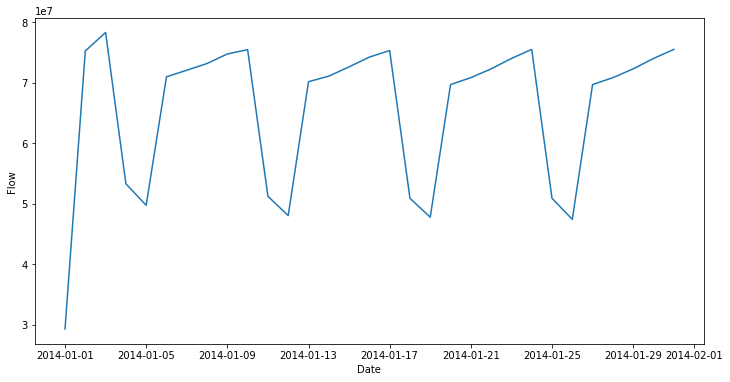

In [17]:
plt.xlabel('Date')
plt.ylabel('Flow')
plt.plot(df.groupby('Date').Flow.sum())
# df.groupby('Date').Flow.sum().plot()

In [18]:
flow = df.groupby('Date').Flow.sum()

## Скользящие стандартное отклонение и среднее

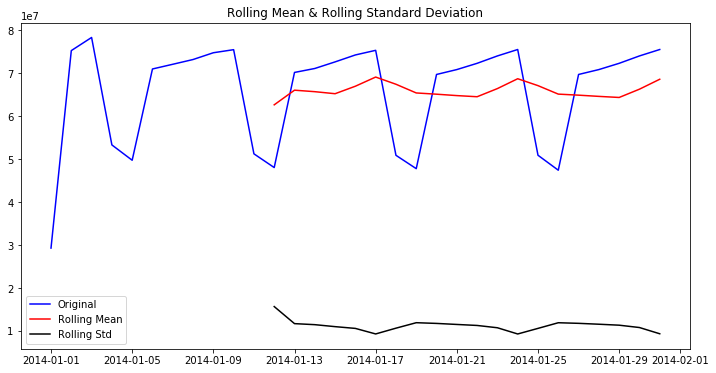

In [24]:
rolling_mean = flow.rolling(window = 12).mean()
rolling_std = flow.rolling(window = 12).std()
plt.plot(flow, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

## Проверяем формат

In [26]:
result = adfuller(flow) # df['Flow'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.277000446176938
p-value: 0.1794931029533126
Critical Values:
	1%: -3.7883858816542486
	5%: -3.013097747543462
	10%: -2.6463967573696143


In [28]:
import statsmodels.api as sm

test = sm.tsa.adfuller(flow)
print('adf: ', test[0] )
print('p-value: ', test[1])
print('Critical values: ', test[4])

adf:  -2.277000446176938
p-value:  0.1794931029533126
Critical values:  {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}


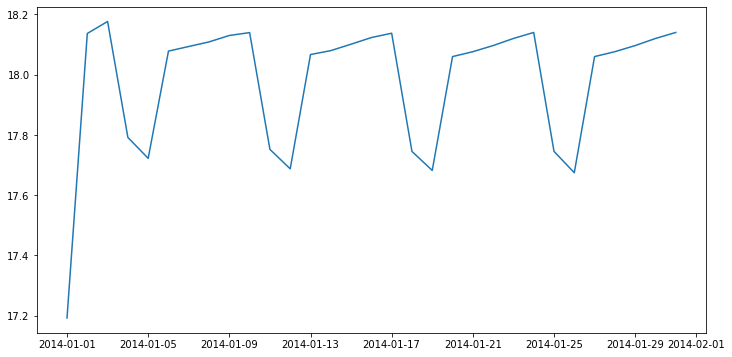

In [29]:
flow_log = np.log(flow)
plt.plot(flow_log)

## Приводим к стационарному виду

In [35]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

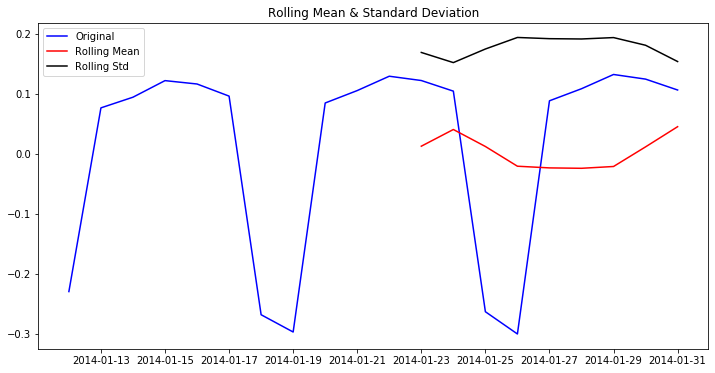

ADF Statistic: -6.582530915649718
p-value: 7.452268579617799e-09
Critical Values:
	1%: -4.137829282407408
	5%: -3.1549724074074077
	10%: -2.7144769444444443


In [36]:
rolling_mean = flow_log.rolling(window=12).mean()
df_log_minus_mean = flow_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

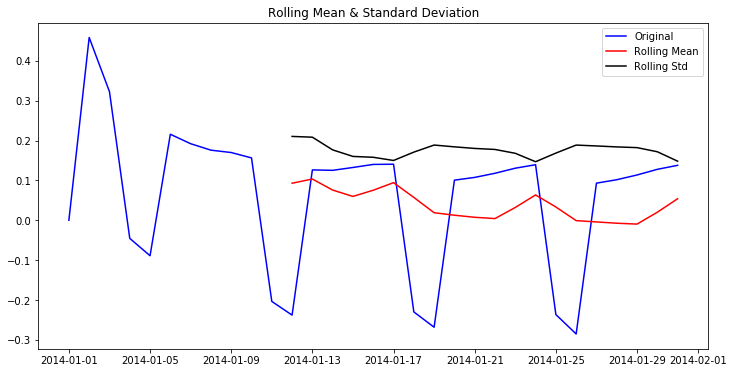

ADF Statistic: -31.30852541709716
p-value: 0.0
Critical Values:
	1%: -3.7529275211638033
	5%: -2.998499866852963
	10%: -2.6389669754253307


In [37]:
rolling_mean_exp_decay = flow_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = flow_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

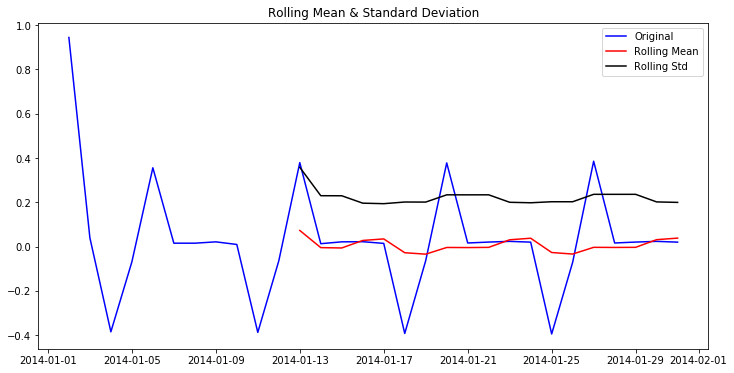

ADF Statistic: -6.4549401805077045
p-value: 1.4914795811592095e-08
Critical Values:
	1%: -3.8092091249999998
	5%: -3.0216450000000004
	10%: -2.6507125


In [38]:
df_log_shift = flow_log - flow_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

## Строим ARIMA

/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


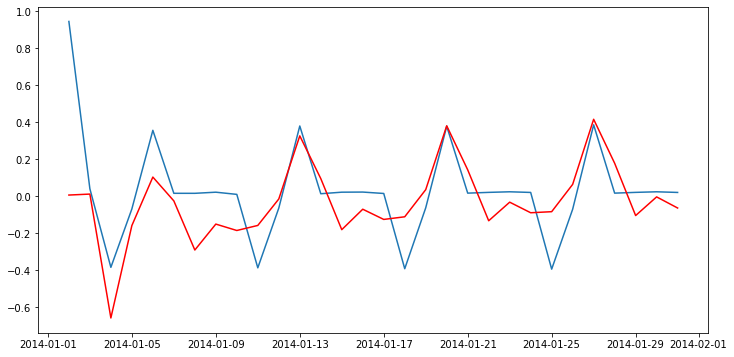

In [39]:
decomposition = seasonal_decompose(flow_log) 
model = ARIMA(flow_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

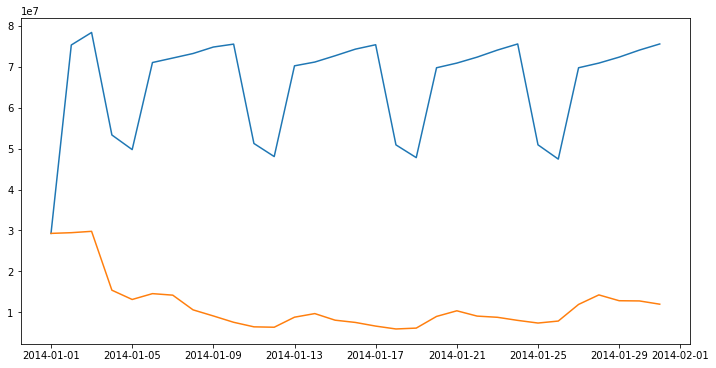

In [41]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(flow_log.iloc[0], index=flow_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(flow)
plt.plot(predictions_ARIMA)

## Строим прогноз

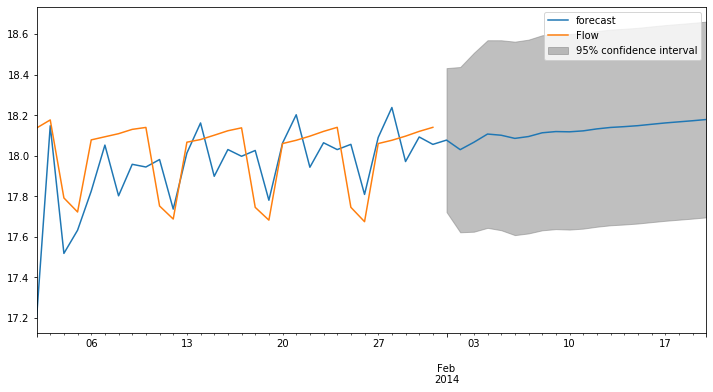

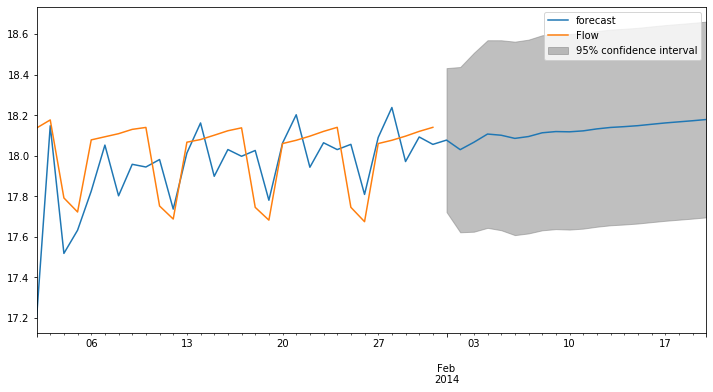

In [43]:
results.plot_predict(1,50)